In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import GRU, Embedding, Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [2]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
train_images_file = '/Users/anwariqbal/Desktop/data/text/Train.txt'
train = load_set(train_images_file)
print('Dataset: %d' % len(train))

Dataset: 80


In [3]:
# Below path contains all the images
images = '/Users/anwariqbal/Desktop/data/images'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

# Below file conatains the names of images to be used in train data
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

# Below file conatains the names of images to be used in test data
test_images_file = '/Users/anwariqbal/Desktop/data/text/Test.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [4]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
    # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [5]:
# descriptions
train_descriptions = load_clean_descriptions('/Users/anwariqbal/Desktop/data/text/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))


Descriptions: train=80


In [6]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [7]:

# Load the inception v3 model
model = InceptionV3(weights='imagenet')
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [9]:
train_features = load(open("/Users/anwariqbal/Desktop/data/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=80


In [18]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)


# Consider only words which occur at least 5 times in the corpus
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
    
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size


# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

preprocessed words 301 -> 112
Description Length: 28


In [19]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

# Load Glove vectors
glove_dir = '/Users/anwariqbal/MCIS/Glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

Found 400000 word vectors.


(113, 200)

In [20]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = GRU(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 28, 200)      22600       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [22]:
model.layers[2]

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [23]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/Users/anwariqbal/Desktop/data/weights/model_' + str(i) + '.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
26/26 [==============================] - 24s 941ms/step - loss: 4.3331
Epoch 1/1
26/26 [==============================] - 17s 673ms/step - loss: 3.7311
Epoch 1/1
26/26 [==============================] - 19s 736ms/step - loss: 3.0614
Epoch 1/1
26/26 [==============================] - 17s 651ms/step - loss: 2.6396
Epoch 1/1
26/26 [==============================] - 16s 627ms/step - loss: 2.3567
Epoch 1/1
26/26 [==============================] - 16s 614ms/step - loss: 2.1221
Epoch 1/1
26/26 [==============================] - 16s 627ms/step - loss: 1.9390
Epoch 1/1
26/26 [==============================] - 17s 644ms/step - loss: 1.7678
Epoch 1/1
26/26 [==============================] - 16s 609ms/step - loss: 1.6587
Epoch 1/1
26/26 [==============================] - 16s 620ms/step - loss: 1.5586


In [24]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/Users/anwariqbal/Desktop/data/weights/model_' + str(i) + '.h5')

Epoch 1/1
26/26 [==============================] - 17s 664ms/step - loss: 1.4880
Epoch 1/1
26/26 [==============================] - 20s 785ms/step - loss: 1.4271
Epoch 1/1
26/26 [==============================] - 18s 682ms/step - loss: 1.3325
Epoch 1/1
26/26 [==============================] - 18s 676ms/step - loss: 1.2547
Epoch 1/1
26/26 [==============================] - 19s 714ms/step - loss: 1.1924
Epoch 1/1
26/26 [==============================] - 19s 749ms/step - loss: 1.1306
Epoch 1/1
26/26 [==============================] - 18s 683ms/step - loss: 1.0784
Epoch 1/1
26/26 [==============================] - 17s 656ms/step - loss: 1.0329
Epoch 1/1
26/26 [==============================] - 19s 748ms/step - loss: 1.0324
Epoch 1/1
26/26 [==============================] - 16s 620ms/step - loss: 0.9337


In [178]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/Users/anwariqbal/Desktop/data/weights/model_' + str(i) + '.h5')

Epoch 1/1
26/26 [==============================] - 15s 559ms/step - loss: 0.9165
Epoch 1/1
26/26 [==============================] - 14s 557ms/step - loss: 0.9066
Epoch 1/1
26/26 [==============================] - 14s 555ms/step - loss: 0.8349
Epoch 1/1
26/26 [==============================] - 14s 551ms/step - loss: 0.7740
Epoch 1/1
26/26 [==============================] - 14s 552ms/step - loss: 0.7600
Epoch 1/1
26/26 [==============================] - 14s 550ms/step - loss: 0.7346
Epoch 1/1
26/26 [==============================] - 14s 554ms/step - loss: 0.7119
Epoch 1/1
26/26 [==============================] - 14s 549ms/step - loss: 0.6786
Epoch 1/1
26/26 [==============================] - 15s 585ms/step - loss: 0.6823
Epoch 1/1
26/26 [==============================] - 15s 572ms/step - loss: 0.6625


In [25]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')
    
model.save_weights('/Users/anwariqbal/Desktop/data/weights/model_30.h5')

Epoch 1/1
13/13 [==============================] - 14s 1s/step - loss: 0.9393
Epoch 1/1
13/13 [==============================] - 15s 1s/step - loss: 0.8905
Epoch 1/1
13/13 [==============================] - 16s 1s/step - loss: 0.7983
Epoch 1/1
13/13 [==============================] - 16s 1s/step - loss: 0.8255
Epoch 1/1
13/13 [==============================] - 15s 1s/step - loss: 0.7387
Epoch 1/1
13/13 [==============================] - 17s 1s/step - loss: 0.7528
Epoch 1/1
13/13 [==============================] - 15s 1s/step - loss: 0.6781
Epoch 1/1
13/13 [==============================] - 17s 1s/step - loss: 0.6581
Epoch 1/1
13/13 [==============================] - 16s 1s/step - loss: 0.6392
Epoch 1/1
13/13 [==============================] - 15s 1s/step - loss: 0.6230


In [26]:
images = '/Users/anwariqbal/Desktop/data/images/'

In [27]:
with open("/Users/anwariqbal/Desktop/data/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [28]:
model.load_weights('/Users/anwariqbal/Desktop/data/weights/model_30.h5')

In [29]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [227]:
list(encoding_test.keys())

['20190910_060250.jpg',
 '20190823_163656.jpg',
 '20190910_062657.jpg',
 '20190823_163527.jpg',
 '20190910_060041.jpg',
 '20190910_051511.jpg',
 '20190910_062619.jpg',
 '20190910_060209.jpg',
 '20190910_062740.jpg',
 '20190823_163355.jpg',
 '20190910_051606.jpg',
 '20190823_163426.jpg',
 '20190910_062549.jpg',
 '20190910_051801.jpg',
 '20190910_051815.jpg',
 '20190910_051642.jpg',
 '20190910_060138.jpg',
 '20190910_062844.jpg',
 '20190910_060329.jpg',
 '20190823_163458.jpg']

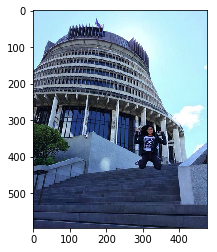

Greedy: man standing in front of beehive building


In [30]:
z=0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

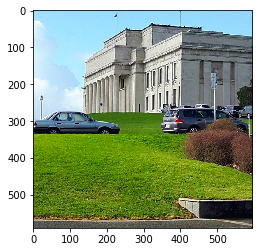

Greedy: auckland war museum with green grass in front


In [31]:
z=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

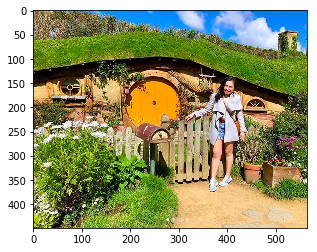

Greedy: hobbiton house with and letter box


In [32]:
z=2
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

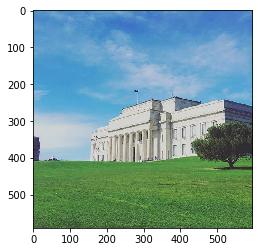

Greedy: auckland war museum with green grass in the front and flags flying


In [33]:
z=3
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

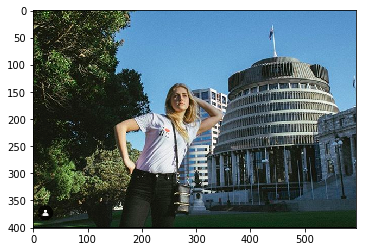

Greedy: man standing in front of beehive building


In [34]:
z=4
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

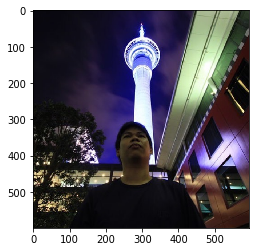

Greedy: sky tower from the base and nearby buildings


In [35]:
z=5
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

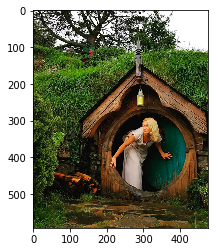

Greedy: hobbiton house with door and people standing at it


In [36]:
z=6
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

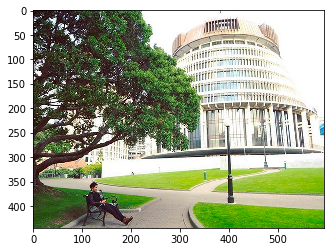

Greedy: man in black sitting outside beehive building


In [37]:
z=7
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

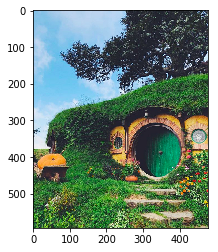

Greedy: hobbiton house with pumpkin outside and brown black and white cat sitting on the bench outside


In [38]:
z=8
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

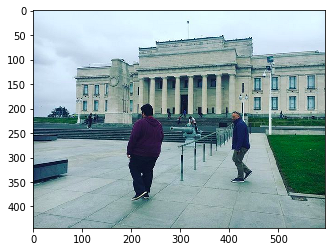

Greedy: auckland war museum with people walking and standing


In [39]:
z=9
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

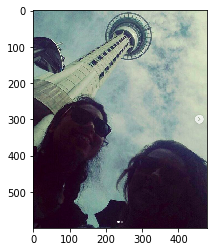

Greedy: woman in shirt and blue jeans standing and looking at the base of the sky tower


In [40]:
z=10
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

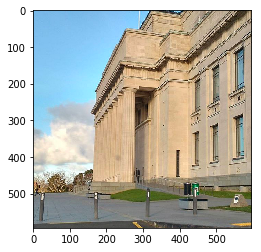

Greedy: auckland war museum with green grass in front


In [41]:
z=11
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

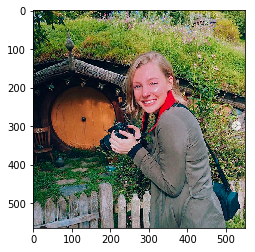

Greedy: hobbiton house with and letter box


In [42]:
z=12
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

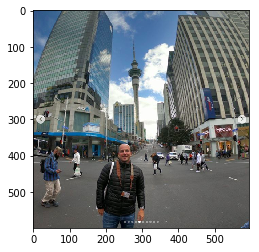

Greedy: woman standing on the street outside beehive building


In [43]:
z=13
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

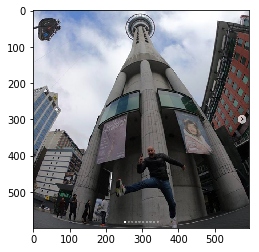

Greedy: sky tower from its base and lit with yellow lights


In [44]:
z=14
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

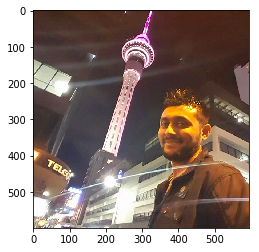

Greedy: woman in shirt and jeans standing and looking at the base of the sky tower


In [45]:
z=15
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

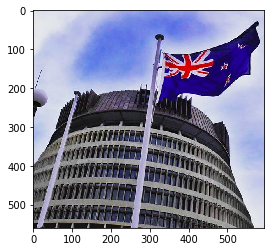

Greedy: the upper of the beehive building with flag flying on top


In [46]:
z=16
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

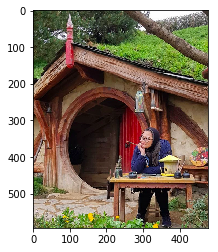

Greedy: hobbiton house with door and man standing at its door


In [47]:
z=17
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

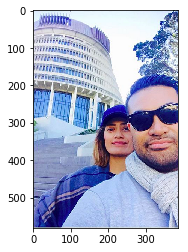

Greedy: woman in black and white sitting outside beehive building


In [48]:
z=18
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

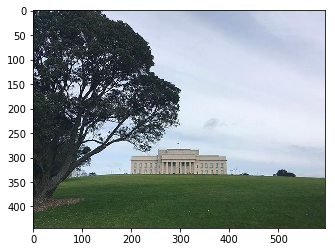

Greedy: auckland war museum with green grass in the front


In [49]:
z=19
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

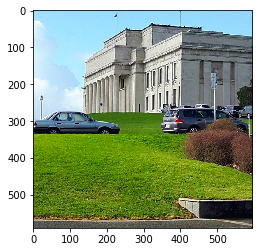

Greedy: auckland war museum with green grass in front


In [50]:
pic = '20190823_163656.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))